# Researching a Pairs Trading Strategy

By Delaney Granizo-Mackenzie and Maxwell Margenot

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---
**I have modified much of the code used in this in order to use Yahoo Data, Kalman filters, and create visualizations.
-Kenny Potts**

---

Pairs trading is a nice example of a strategy based on mathematical analysis. The principle is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. We'll start by constructing an artificial example.

In [2]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
# Just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader.data as web
import scipy as sp
from scipy import stats
from matplotlib import style
import seaborn

from pykalman import KalmanFilter

import itertools

In [3]:
style.use('seaborn-poster')
style.use('seaborn-whitegrid')
style.use('seaborn-notebook')

## Explaining the Concept: We start by generating two fake securities.
We model X's daily returns by drawing from a normal distribution. Then we perform a cumulative sum to get the value of X on each day.

### I will instead use a Laplace Distribution
Better fit for financial data. I will use a location of 0, and then fit a Laplace distribution to AAPL returns in order to determine a realisitc value for the scale (decay) factor.

In [4]:
aapl = web.DataReader('AAPL', data_source='yahoo',
                      start='2013-01-01', end='2015-01-01')

In [5]:
aapl.head()

Open        High         Low       Close     Volume  \
Date                                                                    
2013-01-02  553.819992  554.999992  541.630020  549.029976  140129500   
2013-01-03  547.879990  549.669991  540.999992  542.099991   88241300   
2013-01-04  536.969994  538.630005  525.829979  526.999992  148583400   
2013-01-07  521.999985  529.300018  515.199989  523.900002  121039100   
2013-01-08  529.209976  531.889984  521.250008  525.310020  114676800   

            Adj Close  
Date                   
2013-01-02  71.763763  
2013-01-03  70.857944  
2013-01-04  68.884221  
2013-01-07  68.479021  
2013-01-08  68.663325

In [6]:
loc, scale = stats.laplace.fit_loc_scale(data=aapl['Adj Close'].pct_change()[1:].values)

In [7]:
print('AAPL Laplace Location: ', loc)
print('AAPL Laplace Scale: ', scale)

AAPL Laplace Location:  0.000898038429817
AAPL Laplace Scale:  0.011239951783


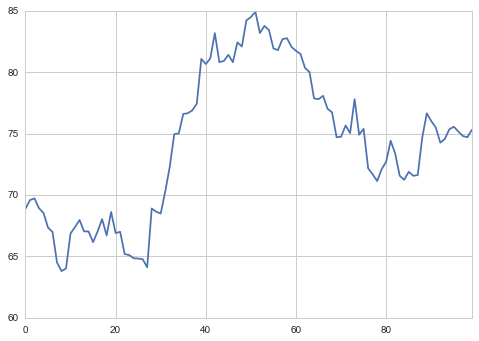

In [8]:
# generate simulated daily returns
X_returns = np.random.laplace(loc=0.0, scale=1, size=100)
# Sum them and shift all the prices into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 70
X.plot();

Now we generate Y. Remember that Y is supposed to have a deep economic link to X, so the price of Y should vary pretty similarly. We model this by taking X, shifting it up and adding some random noise drawn from a normal distribution.

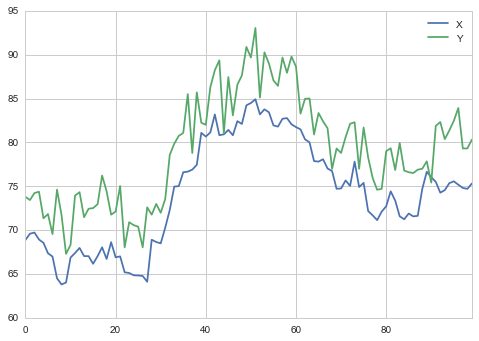

In [9]:
some_noise = np.random.normal(0, 2, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot();

## Def: Cointegration

We've constructed an example of two cointegrated series. Cointegration is a "different" form of correlation (very loosely speaking). If two timeseries are cointegrated, there is some linear combination between them that will vary around a mean. At all points in time, the combination between them is related to the same probability distrribution. 

For more details on how we formally define cointegration and how to understand it, please see the Integration, Cointegration, and Stationarity Lecture from the [Quantopian Lecture Series](https://www.quantopian.com/lectures#Integration,-Cointegration,-and-Stationarity).

We'll plot the difference between the two now so we can see how this looks.

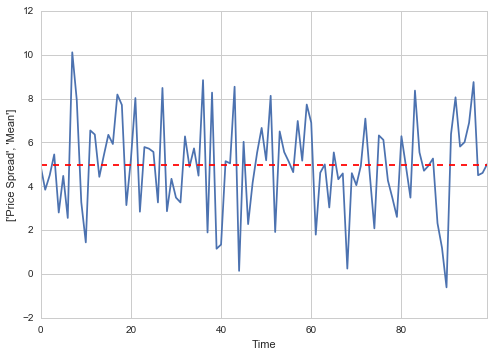

In [10]:
(Y - X).plot() # Plot the spread
plt.axhline((Y-X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.ylabel(['Price Spread','Mean']);

## Testing for Cointegration

That's an intuitive definition, but how do we test for this statisitcally? There is a convenient test that lives in `statsmodels.tsa.stattools`. We should see a very low p-value, as we've artifically created two series that are as cointegrated as physically possible.

In [11]:
# Compute the p-value of the cointegration test
# will inform us as to whether the spread between the 2 timeseries
# is stationary around the mean
score, p_value, _ = coint(X, Y)
print(p_value)

0.71197424832


### Correlation vs. Cointegration

Correlation and cointegration, while theoretically similar, are not the same. To demonstrate this, we'll show examples of series that are correlated, but not cointegrated, and vice versa. To start let's check the correlation of the series we just generated.

In [12]:
X.corr(Y)

0.93987441910568381

That's very high, as we would expect. But how would two series that are correlated but not cointegrated look? 

### Correlation Without Cointegration

A simple example is two series that just diverge.

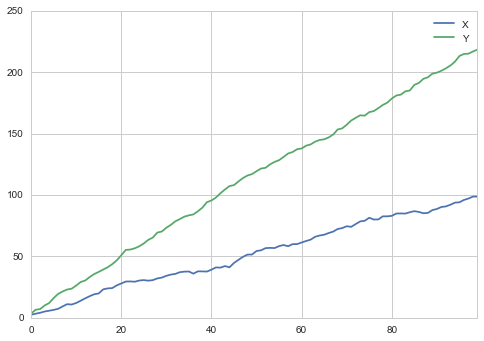

In [13]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot();

In [14]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.995668937533
Cointegration test p-value: 0.432236160766


### Cointegration Without Correlation

A simple example of this case is a normally distributed series and a square wave.

In [15]:
Y2 = pd.Series(np.random.normal(size=1000), name='Y2') + 20
Y3 = Y2.copy()

In [16]:
# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10

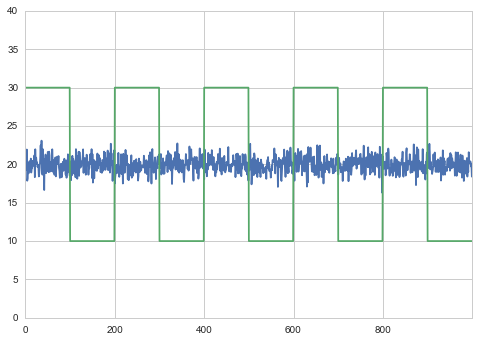

In [17]:
Y2.plot()
Y3.plot()
plt.ylim([0, 40]);

In [18]:
# correlation is nearly zero
print('Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: -0.0437314930501
Cointegration test p-value: 1.96597118974e-06


## Def: Hedged Position
Because you'd like to protect yourself from bad markets, often times short sales will be used to hedge long investments. Because a short sale makes money if the security sold loses value, and a long purchase will make money if a security gains value, one can long parts of the market and short others. That way if the entire market falls off a cliff, we'll still make money on the shorted securities and hopefully break even. In the case of two securities we'll call it a hedged position when we are long on one security and short on the other.

## The Trick: Where it all comes together
Because the securities drift towards and apart from each other, there will be times when the distance is high and times when the distance is low. The trick of pairs trading comes from maintaining a hedged position across X and Y. If both securities go down, we neither make nor lose money, and likewise if both go up. We make money on the spread of the two reverting to the mean. In order to do this we'll watch for when X and Y are far apart, then short Y and long X. Similarly we'll watch for when they're close together, and long Y and short X.

### Going Long the Spread

This is when the spread is small and we expect it to become larger. We place a bet on this by longing Y and shorting X.

### Going Short the Spread

This is when the spread is large and we expect it to become smaller. We place a bet on this by shorting Y and longing X.

### Specific Bets

One important concept here is that we are placing a bet on one specific thing, and trying to reduce our bet's dependency on other factors such as the market.

## Finding real securities that behave like this
The best way to do this is to start with securities you suspect may be cointegrated and perform a statistical test. If you just run statistical tests over all pairs, you'll fall prey to multiple comparison bias.

Here's a method I wrote to look through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05.

### WARNING: This will incur a large amount of multiple comparisons bias. 
For those not familiar with multiple comparisons bias, it is the increased chance to incorrectly generate a significant p-value when many tests are run. If 100 tests are run on random data, we should expect to see 5 p-values below 0.05 on expectation. Because we will perform $n(n-1)/2$ comparisons, we should expect to see many incorrectly significant p-values. For the sake of example will will ignore this and continue. In practice a second verification step would be needed if looking for pairs this way. Another approach is to pick a small number of pairs you have reason to suspect might be cointegrated and test each individually. This will result in less exposure to multiple comparisons bias.

In [19]:
def find_cointegrated_pairs(data, cutoff=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    p_value_matrix = np.zeros((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            s1 = data[keys[i]]
            s2 = data[keys[j]]
            result = coint(s1, s2)
            score = result[0]
            p_value = result[1]
            score_matrix[i, j] = score
            p_value_matrix[i, j] = p_value
            if p_value < cutoff:
                pairs.append((keys[i], keys[j]))
    return score_matrix, p_value_matrix, pairs


## Looking for Cointegrated Pairs of Alternative Energy Securities
I'm looking through a set of solar company stocks to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security for the year of 2014.

### Note
We include the market in our data. This is because the market drives the movement of so many securities that you often times might find two seemingingly cointegrated securities, but in reality they are not cointegrated and just both conintegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find.

#### Note_2 (KP):
I am going to find a more exhaustive list than the one provided on the quantopian lecture. To do this I have found a [list of solar energy stock](https://en.wikipedia.org/wiki/List_of_renewable_energy_companies_by_stock_exchange) on wikipedia, which I will scrape the ticker symbols from. I will only use NYSE and NASDAQ listed companies.

In [20]:
securities = pd.read_html('https://en.wikipedia.org/wiki/List_of_renewable_energy_companies_by_stock_exchange')

In [21]:
securities = securities[0]

In [22]:
securities = securities.loc[1:,:4]

In [23]:
securities.head()

0               1                         2     3  \
1         Company  Exchange place                    Symbol   IPO   
2  7C Solarparken       Frankfurt                 FWB: HRPK     -   
3       A2Z Group          Mumbai  BSE: 533292, NSE: A2ZMES   NaN   
4     Abengoa, SA          Madrid                 BMAD: ABG     -   
5      Aleo solar       Frankfurt                  FWB: AS1  2006   

               4  
1       Industry  
2     Renewables  
3  Solar Thermal  
4  Solar Thermal  
5  Photovoltaics

In [24]:
securities.rename(columns=securities.iloc[0,:], inplace=True)

In [25]:
securities = securities.iloc[1:,:]

In [26]:
securities.head()

Company Exchange place                    Symbol   IPO  \
2              7C Solarparken      Frankfurt                 FWB: HRPK     -   
3                   A2Z Group         Mumbai  BSE: 533292, NSE: A2ZMES   NaN   
4                 Abengoa, SA         Madrid                 BMAD: ABG     -   
5                  Aleo solar      Frankfurt                  FWB: AS1  2006   
6  Clean Power Investors, LTD         London                  LSE: ALR  2004   

        Industry  
2     Renewables  
3  Solar Thermal  
4  Solar Thermal  
5  Photovoltaics  
6     Renewables

In [27]:
s = pd.DataFrame(securities['Symbol'].str.split(':'))

In [28]:
exch_symbols = pd.DataFrame([ str(x).split(':') for x in securities['Symbol'].tolist() ]).iloc[:,:2]

In [29]:
symbols = []
for i in range(len(exch_symbols)):
    exchange = exch_symbols.iloc[i,0]
    symbol = exch_symbols.iloc[i,1]
    if exchange in ['NYSE', 'NASDAQ']:
        symbols.append(symbol[1:])
        # print(symbols[-1])

In [30]:
symbols

['AVR',
 'BLDP',
 'BEP',
 'CSIQ',
 'CSUN',
 'DSTI',
 'ENPH',
 'FSLR',
 'GEVO',
 'GPRE',
 'GTAT',
 'JASO',
 'LDK',
 'OPTT',
 'ORA',
 'SOL',
 'REGI',
 'SCTY',
 'SOLF',
 'SUNE',
 'SPWR',
 'RUN',
 'STP',
 'TSL',
 'VRNM',
 'VSLR',
 'YGE']

In [31]:
# Add SPY to the list
symbols.append('SPY')

In [32]:
prices = web.DataReader(symbols, data_source='yahoo',
                        start='2014-01-01', end='2015-01-01')[('Adj Close')]

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'AVR', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'GTAT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'LDK', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'SOLF', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'SUNE', repla

In [33]:
prices.head()

AVR        BEP  BLDP       CSIQ  CSUN  DSTI  ENPH       FSLR  \
Date                                                                       
2014-01-01  NaN        NaN   NaN        NaN   NaN   NaN   NaN        NaN   
2014-01-02  NaN  21.964812  1.75  34.189999  7.09  0.29  6.78  57.439999   
2014-01-03  NaN  22.256123  1.86  35.240002  7.08  0.29  6.92  56.740002   
2014-01-06  NaN  22.189538  1.85  35.730000  7.00  0.29  7.04  51.259998   
2014-01-07  NaN  21.981459  2.47  38.570000  6.93  0.31  7.54  52.490002   

                  GEVO       GPRE    ...            SOL  SOLF       SPWR  \
Date                                 ...                                   
2014-01-01         NaN        NaN    ...            NaN   NaN        NaN   
2014-01-02  422.999567  18.000563    ...      19.700000   NaN  32.299999   
2014-01-03  413.999576  18.000563    ...      20.350001   NaN  32.730000   
2014-01-06  413.999576  17.745034    ...      21.150000   NaN  32.439999   
2014-01-07  401.999589  17.972171    ...      21.099999   NaN  32.730000   

                   SPY     STP  SUNE    TSL  VRNM  VSLR        YGE  
Date                                                                
2014-01-01         NaN  0.1398   NaN    NaN   NaN   NaN        NaN  
2014-01-02  171.345826  0.1511   NaN  14.98   NaN   NaN  62.800000  
2014-01-03  171.317726  0.1511   NaN  15.35   NaN   NaN  66.099999  
2014-01-06  170.821262  0.1511   NaN  16.02   NaN   NaN  65.300004  
2014-01-07  171.870390  0.1624   NaN  16.51   NaN   NaN  70.800004  

[5 rows x 28 columns]

In [34]:
# Some cleaning of missing data (failed to download, and missing days)
prices = prices.drop('STP', axis=1).dropna(axis=1,how='all').dropna(axis=0, how='all')

In [35]:
prices.head()

BEP  BLDP       CSIQ  CSUN  DSTI  ENPH       FSLR  \
Date                                                                  
2014-01-02  21.964812  1.75  34.189999  7.09  0.29  6.78  57.439999   
2014-01-03  22.256123  1.86  35.240002  7.08  0.29  6.92  56.740002   
2014-01-06  22.189538  1.85  35.730000  7.00  0.29  7.04  51.259998   
2014-01-07  21.981459  2.47  38.570000  6.93  0.31  7.54  52.490002   
2014-01-08  21.864935  2.27  38.430000  7.17  0.30  7.25  51.680000   

                  GEVO       GPRE   JASO       OPTT        ORA   REGI  \
Date                                                                    
2014-01-02  422.999567  18.000563   9.95  20.599999  26.181642  11.84   
2014-01-03  413.999576  18.000563   9.71  20.300000  26.094305  11.79   
2014-01-06  413.999576  17.745034   9.76  22.600001  25.832296  11.47   
2014-01-07  401.999589  17.972171   9.82  22.200001  25.861407  11.26   
2014-01-08  407.999582  18.019492  10.29  21.900002  25.531467  10.90   

                 SCTY        SOL       SPWR         SPY    TSL  VSLR  \
Date                                                                   
2014-01-02  59.709999  19.700000  32.299999  171.345826  14.98   NaN   
2014-01-03  59.270000  20.350001  32.730000  171.317726  15.35   NaN   
2014-01-06  63.610001  21.150000  32.439999  170.821262  16.02   NaN   
2014-01-07  63.720001  21.099999  32.730000  171.870390  16.51   NaN   
2014-01-08  66.180000  20.850000  33.029999  171.907867  16.82   NaN   

                  YGE  
Date                   
2014-01-02  62.800000  
2014-01-03  66.099999  
2014-01-06  65.300004  
2014-01-07  70.800004  
2014-01-08  72.400003

That looks nice and clean.

Now we'll run our method on the list and see if any pairs are cointegrated.

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1591: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1018: UserWarning: y0 and y1 are perfectly colinear.  Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are perfectly colinear.  Cointegration test "


[('ORA', 'REGI'), ('ORA', 'SCTY'), ('ORA', 'SOL'), ('ORA', 'SPWR'), ('ORA', 'SPY'), ('ORA', 'TSL'), ('ORA', 'YGE')]


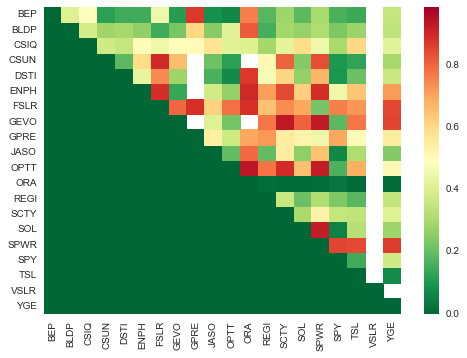

In [36]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

scores, p_values, pairs = find_cointegrated_pairs(prices)

seaborn.heatmap(p_values, xticklabels=prices.columns.tolist(),
                yticklabels=prices.columns.tolist(), cmap='RdYlGn_r',
                mask=(p_values >= 0.95))

print(pairs)

Looks like 'BLDP' and 'REGI' are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on.

A Closer look shows that DSTI Looks like a penny stock maybe? - Might make it appear to be cointegrated with many assets.

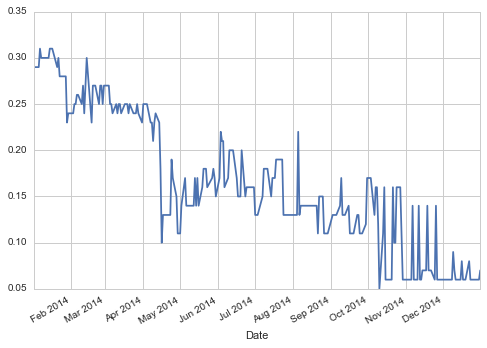

In [37]:
prices['DSTI'].plot();

In [38]:
s1 = prices['BLDP']
s2 = prices['REGI']

In [39]:
score, p_value, _ = coint(s1, s2)
p_value

0.15734842792863685

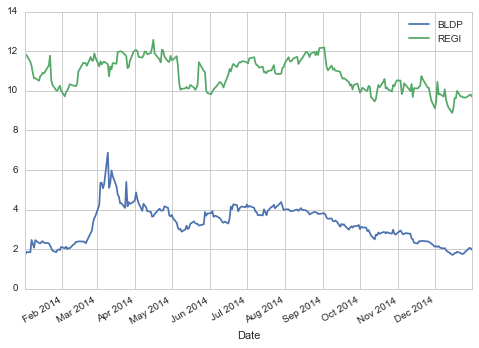

In [40]:
prices['BLDP'].plot()
prices['REGI'].plot()
plt.legend()

We'll plot the spread of the two series. Here we use linear regression to calculate a coefficient for their linear combination.

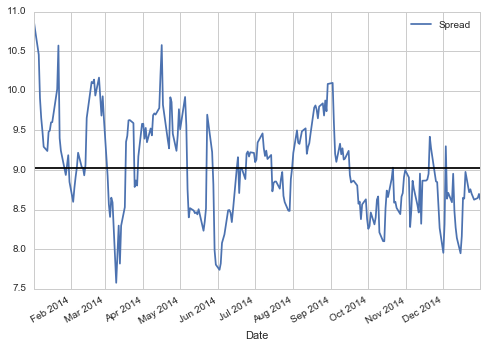

In [41]:
s1 = sm.add_constant(s1)
result = sm.OLS(s2, s1).fit()
s1 = s1['BLDP']
b = result.params['BLDP']

spread = s2 - b * s1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

We can also look at the ratio between the two series.

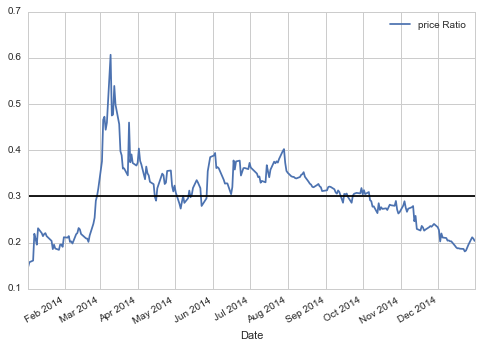

In [42]:
ratio = s1/s2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['price Ratio']);

Examining the price ratio of a trading pair is a traditional way to handle pairs trading. Part of why this works as a signal is based in our assumptions of how stock prices move, specifically because stock prices are typically assumed to be log-normally distributed. What this implies is that by taking a ratio of the prices, we are taking a linear combination of the returns associated with them (since prices are just the exponentiated returns).

This can be a little irritating to deal with for our purposes as purchasing the precisely correct ratio of a trading pair may not be practical. We choose instead to move forward with simply calculating the spread between the cointegrated stocks using linear regression. This is a very simple way to handle the relationship, however, and is likely not feasible for non-toy examples. There are other potential methods for estimating the spread listed at the bottom of this lecture. If you want to get more into the theory of why having cointegrated stocks matters for pairs trading, again, please see the Integration, Cointegration, and Stationarity Lecture from the [Quantopian Lecture Series](https://www.quantopian.com/lectures#Integration,-Cointegration,-and-Stationarity).

So, back to our example. The absolute spread isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. 

### WARNING

In practice this is usually done to try to give some scale to the data, but this assumes some underlying distribution. Usually normal. Under a normal distribution, we would know that approximately 84% of all spread values will be smaller. However, much financial data is not normally distributed, and one must be very careful not to assume normality, nor any specific distribution when generating statistics. It could be the case that the true distribution of spreads was very fat-tailed and prone to extreme values. This could mess up our model and result in large losses.

In [43]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

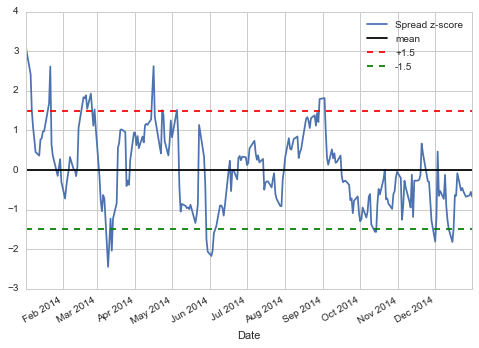

In [44]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.legend(['Spread z-score','mean','+1.5','-1.5']);

### Simple Strategy: 
* Go "Long" the spread whenever the z-score is below -1.0 **(maybe -1.5?? - KP)**
* Go "Short" the spread when the z-score is above 1.0 **(maybe 1.5?? - KP)**
* Exit positions when the z-score approaches zero

This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts.  In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2.  Some additional resources on pair trading are listed at the end of this notebook

## Trading using constantly updating statistics

In general taking a statistic over your whole sample size can be bad. For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

## Def: Moving Average
A moving average is just an average over the last $n$ datapoints for each given time. It will be undefined for the first $n$ datapoints in our series. Shorter moving averages will be more jumpy and less reliable, but respond to new information quickly. Longer moving averages will be smoother, but take more time to incorporate new information.

We also need to use a rolling beta, a rolling estimate of how our spread should be calculated, in order to keep all of our parameters up to date.

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  app.launch_new_instance()


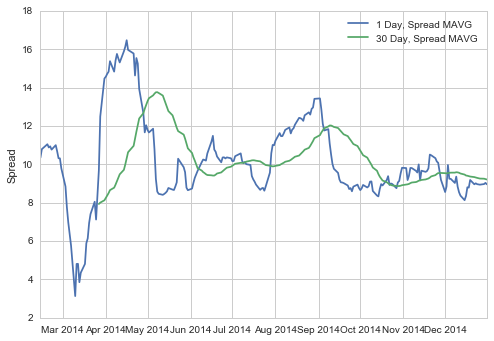

In [45]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
rolling_beta = pd.ols(y=s1, x=s2, window_type='rolling', window=30)
spread = s2 - rolling_beta.beta['x'] * s1
spread.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavd'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day, Spread MAVG', '30 Day, Spread MAVG'])

plt.ylabel('Spread');


It appears that pandas has deprecated the OLS module, that is ok because it might be better to implement the moving beta estimation with a **Kalman filter!** This can be seen in the Kalman filter lecture, but I will steal from that lecture and implement it here with this example.

In [46]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[s1.values], [np.ones(len(s1))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional ,(alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

In [47]:
# Use the obsercations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(s2.values)

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


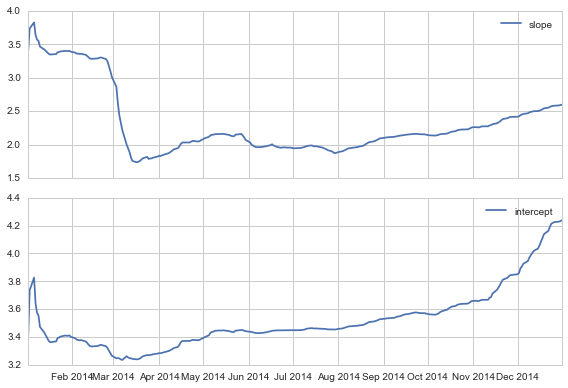

In [48]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(s1.index, state_means[:,0], label='slope')
axarr[0].legend();
axarr[1].plot(s1.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

**And again we can implement a Kalman filter on the spread!**

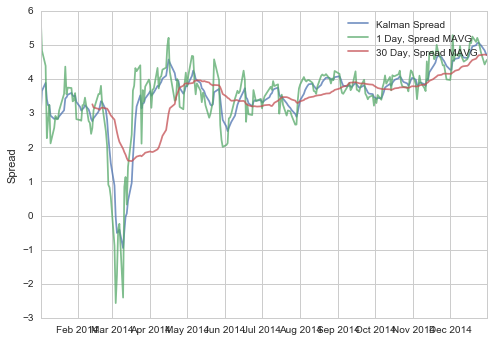

In [49]:

spread = s2 - state_means[:,0] * s1
spread.name = 'spread'

# Construct a Kalman Filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.1)

# Use the observed values of the price to get a rolling mean
state_means2, _ = kf.filter(spread.values)

kalman_spread = pd.Series(state_means2.flatten(), index=spread.index)
kalman_spread.name = 'Kalman Spread'


# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavd'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'


plt.plot(kalman_spread, alpha=0.75)
plt.plot(spread_mavg1.index, spread_mavg1.values, alpha=0.75)
plt.plot(spread_mavg30.index, spread_mavg30.values, alpha=0.75)

plt.legend([kalman_spread.name, '1 Day, Spread MAVG', '30 Day, Spread MAVG'])

plt.ylabel('Spread');


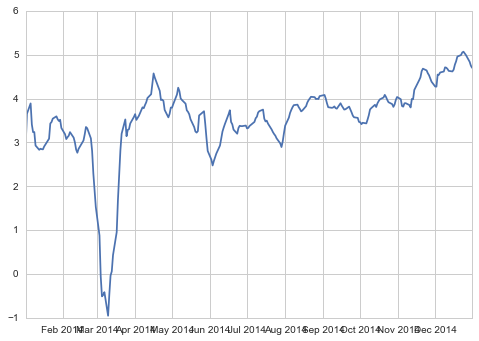

In [50]:
plt.plot(kalman_spread);

We can use the moving averages to compute the z-score of the spread at each given time. This will tell us how extreme the spread is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

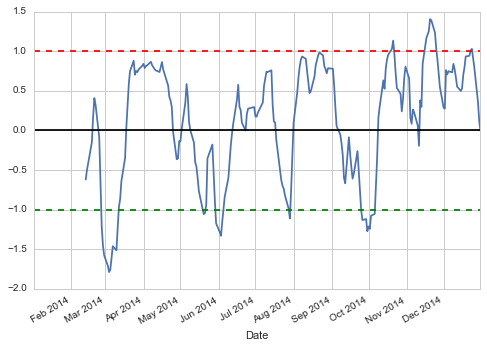

In [51]:
# Take a rolling 30 dy standard deviation
std_30 = spread.rolling(window=30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (kalman_spread - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--');

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like. We'll take the negative of the z-score because the spreads were all negative and that is a little counterintuitive to trade on.

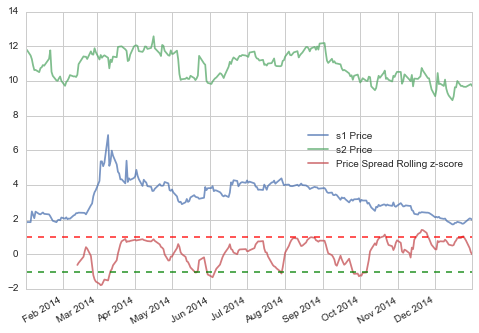

In [54]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock price by 10 to make viewing it on the plot easier
plt.plot(s1.index, s1.values, alpha=0.75)
plt.plot(s2.index, s2.values, alpha=0.75)
plt.plot(zscore_30_1.index, zscore_30_1.values, alpha=0.75)
plt.axhline(1.0, color='red', linestyle='--', alpha=0.75)
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.75);
plt.legend(['s1 Price', 's2 Price', 'Price Spread Rolling z-score'],loc='best');
fig = plt.gcf()
fig.autofmt_xdate()
fig.savefig('/Users/kennypotts/Desktop/pic1.png')

#### Note (KP):
We are using a 30 day rolling standard deviation calc and have selected our cutoffs to +/- 1 $\sigma$. Both of these could be altered to yield different results. Perhaps these could be optimized as well? Perhaps we could implement yet another kalman filter for the sandard deviation calculations. - **Maybe someone wants to look into this.**

## Try it again!
**Let's repeat the process with another pair from the heatamp.**

In [55]:
s1 = prices['BLDP']
s2 = prices['FSLR']

score, p_value, _ = coint(s1, s2)
p_value

0.14935070859700544

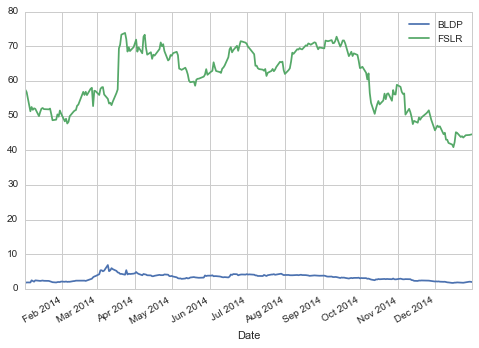

In [56]:
prices['BLDP'].plot()
prices['FSLR'].plot()
plt.legend();

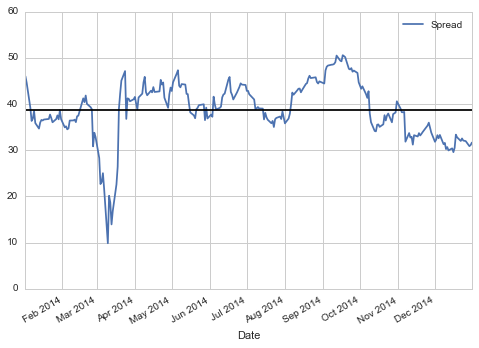

In [57]:
s1 = sm.add_constant(s1)
result = sm.OLS(s2, s1).fit()
s1 = s1['BLDP']
b = result.params['BLDP']

spread = s2 - b * s1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

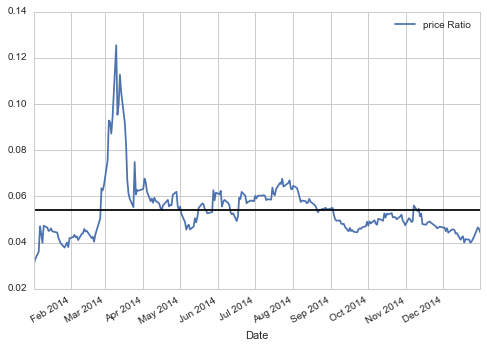

In [58]:
ratio = s1/s2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['price Ratio']);

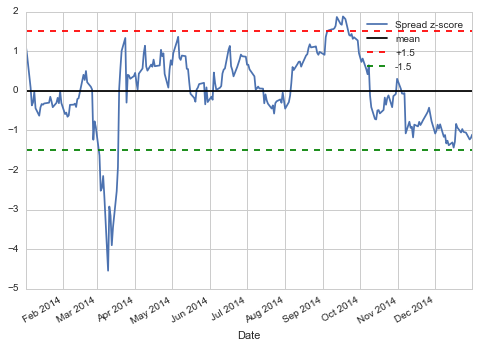

In [59]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.legend(['Spread z-score','mean','+1.5','-1.5']);

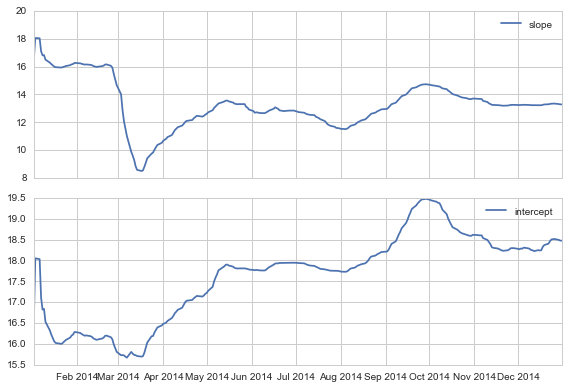

In [60]:
# Rolling Kalman coint beta

delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[s1.values], [np.ones(len(s1))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional ,(alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)
# Use the obsercations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(s2.values)

_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(s1.index, state_means[:,0], label='slope')
axarr[0].legend();
axarr[1].plot(s1.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

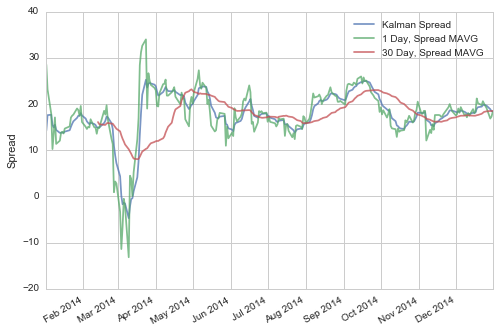

In [63]:
spread = s2 - state_means[:,0] * s1
spread.name = 'spread'

# Construct a Kalman Filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.1)

# Use the observed values of the price to get a rolling mean
state_means2, _ = kf.filter(spread.values)

kalman_spread = pd.Series(state_means2.flatten(), index=spread.index)
kalman_spread.name = 'Kalman Spread'


# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavd'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'


plt.plot(kalman_spread, alpha=0.75)
plt.plot(spread_mavg1.index, spread_mavg1.values, alpha=0.75)
plt.plot(spread_mavg30.index, spread_mavg30.values, alpha=0.75)

plt.legend([kalman_spread.name, '1 Day, Spread MAVG', '30 Day, Spread MAVG'])

plt.ylabel('Spread');

fig = plt.gcf()
fig.autofmt_xdate()
fig.savefig('/Users/kennypotts/Desktop/pic1.png');

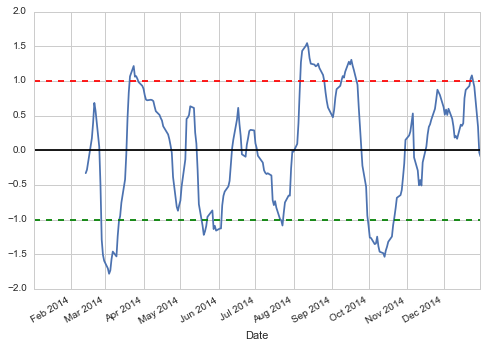

In [62]:
# Take a rolling 30 dy standard deviation
std_30 = spread.rolling(window=30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (kalman_spread - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--');

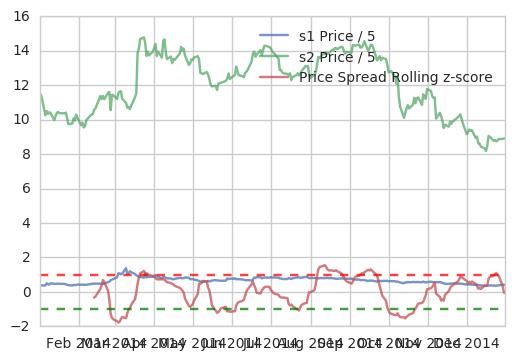

In [347]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock price by 10 to make viewing it on the plot easier
plt.plot(s1.index, s1.values/5, alpha=0.75)
plt.plot(s2.index, s2.values/5, alpha=0.75)
plt.plot(zscore_30_1.index, zscore_30_1.values, alpha=0.75)
plt.axhline(1.0, color='red', linestyle='--', alpha=0.75)
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.75);
plt.legend(['s1 Price / 5', 's2 Price / 5', 'Price Spread Rolling z-score']);

## A Third Pair!

In [348]:
s1 = prices['CSUN']
s2 = prices['TSL']

score, p_value, _ = coint(s1, s2)
p_value

0.0033018541991984862

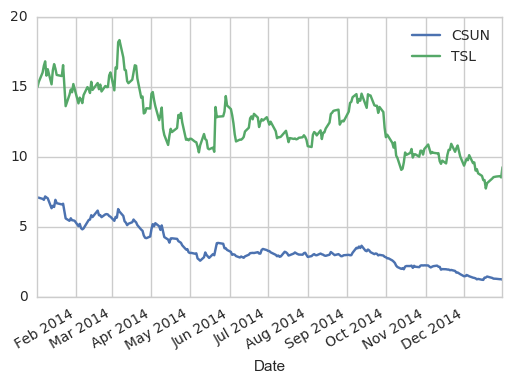

In [349]:
prices['CSUN'].plot()
prices['TSL'].plot()
plt.legend();

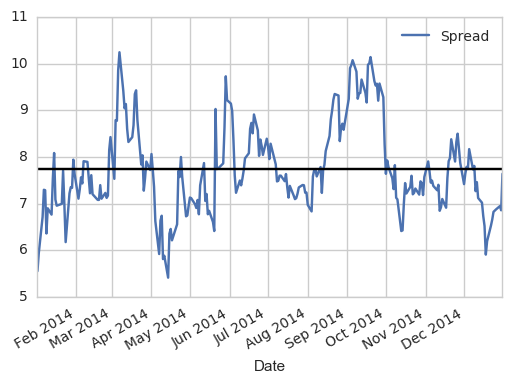

In [350]:
s1 = sm.add_constant(s1)
result = sm.OLS(s2, s1).fit()
s1 = s1['CSUN']
b = result.params['CSUN']

spread = s2 - b * s1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

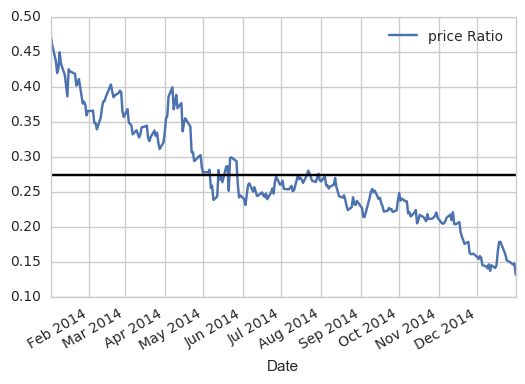

In [351]:
ratio = s1/s2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['price Ratio']);

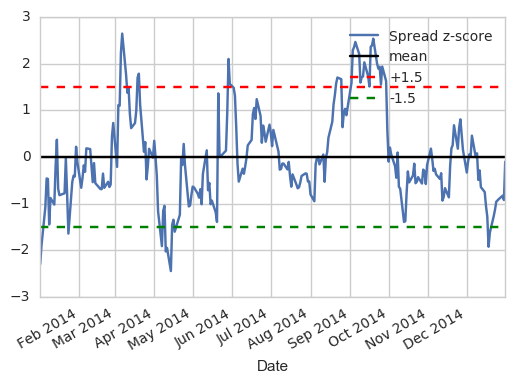

In [352]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.legend(['Spread z-score','mean','+1.5','-1.5']);

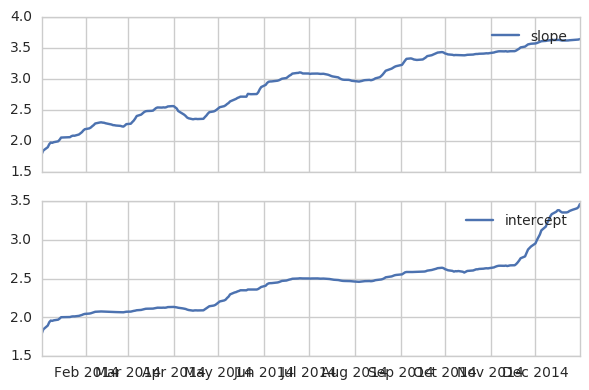

In [353]:
# Rolling Kalman coint beta

delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[s1.values], [np.ones(len(s1))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional ,(alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)
# Use the obsercations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(s2.values)

_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(s1.index, state_means[:,0], label='slope')
axarr[0].legend();
axarr[1].plot(s1.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

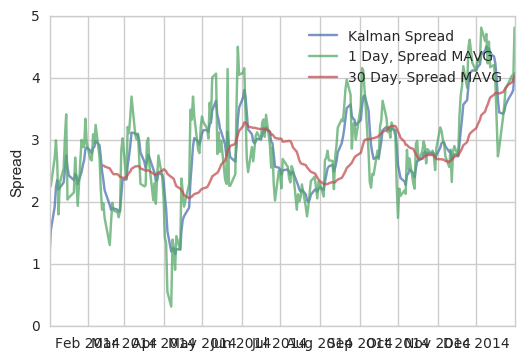

In [354]:
spread = s2 - state_means[:,0] * s1
spread.name = 'spread'

# Construct a Kalman Filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.1)

# Use the observed values of the price to get a rolling mean
state_means2, _ = kf.filter(spread.values)

kalman_spread = pd.Series(state_means2.flatten(), index=spread.index)
kalman_spread.name = 'Kalman Spread'


# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavd'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'


plt.plot(kalman_spread, alpha=0.75)
plt.plot(spread_mavg1.index, spread_mavg1.values, alpha=0.75)
plt.plot(spread_mavg30.index, spread_mavg30.values, alpha=0.75)

plt.legend([kalman_spread.name, '1 Day, Spread MAVG', '30 Day, Spread MAVG'])

plt.ylabel('Spread');

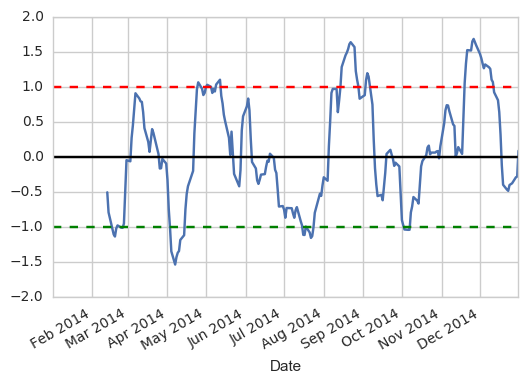

In [355]:
# Take a rolling 30 dy standard deviation
std_30 = spread.rolling(window=30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (kalman_spread - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--');

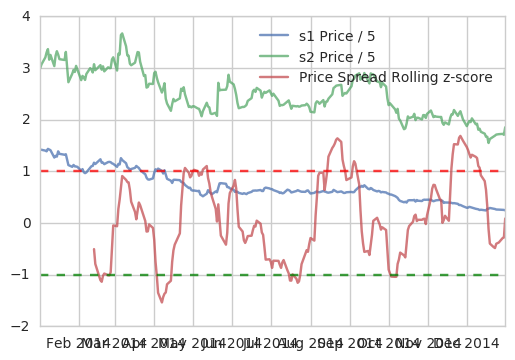

In [357]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock price by 10 to make viewing it on the plot easier
plt.plot(s1.index, s1.values/5, alpha=0.75)
plt.plot(s2.index, s2.values/5, alpha=0.75)
plt.plot(zscore_30_1.index, zscore_30_1.values, alpha=0.75)
plt.axhline(1.0, color='red', linestyle='--', alpha=0.75)
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.75);
plt.legend(['s1 Price / 5', 's2 Price / 5', 'Price Spread Rolling z-score']);

# Out of Sample Test
I chose these pairs to look at only because the cointegration test showed that they were **cointegrated over the entire period**. The very fist thing I did to produce the heatmap was run a cointegration test over teh entire period. So I essentially had future knowledge that the relationship would persist, let's see if this relationship persists on pricing data that I have not yet seen.

In [372]:
symbols_test = ['BLDP','REGI','FSLR','CSUN','TSL']
prices_test = web.DataReader(symbols_test, data_source='yahoo',
                        start='2015-01-01', end='2016-01-01')[('Adj Close')]

In [373]:
s1 = prices_test['BLDP']
s2 = prices_test['REGI']

score, p_value, _ = coint(s1, s2)
p_value

0.54489617181330574

In [374]:
s1 = prices_test['BLDP']
s2 = prices_test['FSLR']

score, p_value, _ = coint(s1, s2)
p_value

0.66586445995570165

In [375]:
s1 = prices_test['CSUN']
s2 = prices_test['TSL']

score, p_value, _ = coint(s1, s2)
p_value

0.349065547503701

### **It appears that out of sample the relationship is not there. :( **

This may be harder than expected. Maybe we can track the cointegration p-value over a rolling period.

In [424]:
prices = prices.drop('DSTI', axis=1)

In [425]:
def find_cointegrated_pairs_full(data, cutoff=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    p_value_matrix = np.zeros((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(n):
            s1 = data[keys[i]]
            s2 = data[keys[j]]
            result = coint(s1, s2)
            score = result[0]
            p_value = result[1]
            score_matrix[i, j] = score
            p_value_matrix[i, j] = p_value
            if p_value < cutoff:
                pairs.append((keys[i], keys[j]))
    return score_matrix, p_value_matrix, pairs


/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1546: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:929: RuntimeWarning: divide by zero encountered in double_scalars
  coint_t = (uroot_reg.params[0] - 1) / uroot_reg.bse[0]
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:929: RuntimeWarning: invalid value encountered in double_scalars
  coint_t = (uroot_reg.params[0] - 1) / uroot_reg.bse[0]
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater_equal


[('BEP', 'CSUN'), ('BEP', 'GEVO'), ('BEP', 'SPY'), ('BEP', 'TSL'), ('BEP', 'YGE'), ('BLDP', 'BLDP'), ('BLDP', 'FSLR'), ('BLDP', 'JASO'), ('BLDP', 'REGI'), ('CSUN', 'BEP'), ('CSUN', 'OPTT'), ('CSUN', 'TSL'), ('CSUN', 'YGE'), ('FSLR', 'FSLR'), ('GEVO', 'GEVO'), ('GEVO', 'OPTT'), ('JASO', 'BLDP'), ('JASO', 'CSUN'), ('JASO', 'ENPH'), ('JASO', 'GEVO'), ('JASO', 'JASO'), ('JASO', 'OPTT'), ('JASO', 'REGI'), ('JASO', 'SOL'), ('JASO', 'SPY'), ('OPTT', 'GEVO'), ('REGI', 'BLDP'), ('REGI', 'FSLR'), ('REGI', 'JASO'), ('REGI', 'OPTT'), ('REGI', 'REGI'), ('REGI', 'SCTY'), ('REGI', 'SOL'), ('REGI', 'SPWR'), ('SOL', 'SOL'), ('SOL', 'TSL'), ('TSL', 'CSUN'), ('TSL', 'SOL'), ('TSL', 'TSL'), ('TSL', 'YGE'), ('YGE', 'CSUN')]


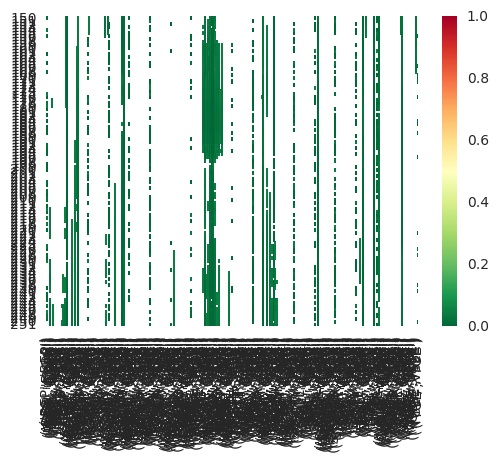

In [434]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

k = 150
# start k days into 2015
p_vals_time = []
for i in range(k,len(prices)):
    scores, p_values, pairs = find_cointegrated_pairs_full(prices.iloc[:i,:])
    p_vals_time.append(p_values.flatten())
    
p_vals_time = np.asanyarray(p_vals_time)
seaborn.heatmap(p_vals_time,
                xticklabels=list(itertools.product(prices.columns.tolist(),
                                                   prices.columns.tolist())),
                yticklabels=range(k, len(prices)), cmap='RdYlGn_r',
                mask=p_vals_time >= 0.05)

print(pairs)

The visualization above needs some serious work. Perhaps there is a better way to visualize this. Attempting to view the how to the cointegration relationship changes over time among the stocks. It may be best to first view this with a single stock, or perhaps a plot would be better.

Either way, it is clear that these relationships come and go.

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1546: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:929: RuntimeWarning: divide by zero encountered in double_scalars
  coint_t = (uroot_reg.params[0] - 1) / uroot_reg.bse[0]
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:929: RuntimeWarning: invalid value encountered in double_scalars
  coint_t = (uroot_reg.params[0] - 1) / uroot_reg.bse[0]


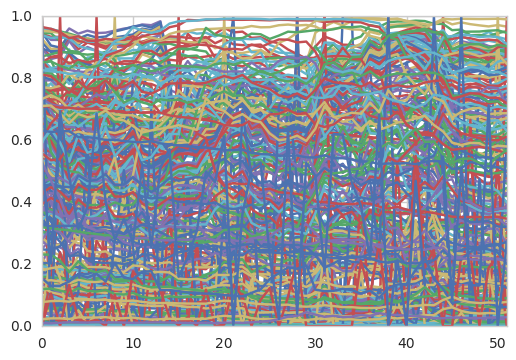

In [440]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

k = 200
# start k days into 2015
columns = list(itertools.product(prices.columns.tolist(),
                                 prices.columns.tolist()))
p_vals_time = pd.DataFrame(np.zeros((len(prices.iloc[k:,:]),
                                     len(columns))),
                           columns=columns)
for i in range(k,len(prices)):
    scores, p_values, pairs = find_cointegrated_pairs_full(prices.iloc[:i,:])
    p_vals_time.iloc[i-k,:] = p_values.flatten()
    
p_vals_time.plot(legend=None)

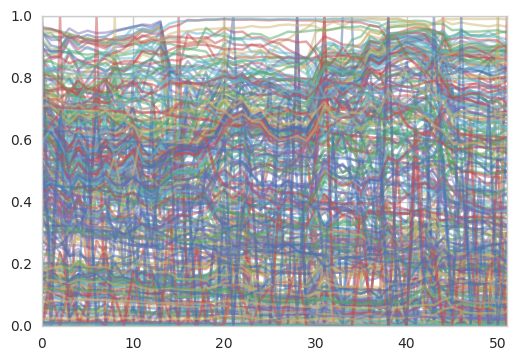

In [441]:
p_vals_time.plot(legend=None, alpha=0.5)

In [479]:
p_vals_time.shape

(52, 361)

In [460]:
len(p_vals_time[p_vals_time < 0.05].all().index)

361

In [475]:
potential_pairs_idx = np.where((~(p_vals_time[p_vals_time > 0.05] == p_vals_time).all()))[0]

In [478]:
p_vals_time[potential_pairs_idx].shape

(52, 92)

In [481]:
p_vals_time[potential_pairs_idx].columns

Index([  ('BEP', 'BEP'),  ('BEP', 'CSUN'),  ('BEP', 'GEVO'),   ('BEP', 'SPY'),
         ('BEP', 'TSL'),  ('BEP', 'VSLR'),   ('BEP', 'YGE'), ('BLDP', 'BLDP'),
       ('BLDP', 'FSLR'), ('BLDP', 'JASO'),  ('BLDP', 'ORA'), ('BLDP', 'REGI'),
       ('BLDP', 'VSLR'), ('CSIQ', 'CSIQ'), ('CSIQ', 'VSLR'),  ('CSUN', 'BEP'),
       ('CSUN', 'CSUN'), ('CSUN', 'OPTT'),  ('CSUN', 'TSL'), ('CSUN', 'VSLR'),
        ('CSUN', 'YGE'), ('ENPH', 'ENPH'), ('ENPH', 'VSLR'), ('FSLR', 'FSLR'),
       ('FSLR', 'VSLR'), ('GEVO', 'GEVO'), ('GEVO', 'OPTT'), ('GEVO', 'VSLR'),
       ('GPRE', 'GPRE'), ('GPRE', 'VSLR'),  ('JASO', 'BEP'), ('JASO', 'BLDP'),
       ('JASO', 'CSUN'), ('JASO', 'ENPH'), ('JASO', 'GEVO'), ('JASO', 'JASO'),
       ('JASO', 'OPTT'), ('JASO', 'REGI'),  ('JASO', 'SOL'),  ('JASO', 'SPY'),
       ('JASO', 'VSLR'), ('OPTT', 'GEVO'), ('OPTT', 'OPTT'), ('OPTT', 'VSLR'),
         ('ORA', 'ORA'),  ('ORA', 'VSLR'), ('REGI', 'BLDP'), ('REGI', 'FSLR'),
       ('REGI', 'JASO'), ('REGI', 'OPTT'), ('REGI', 

Many of these pairs are repeats since it contains all pairs (x,x), (x,y), (y,x).

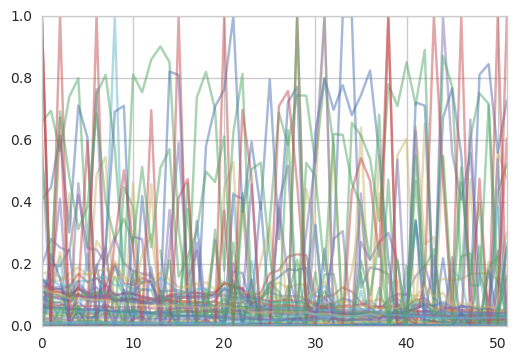

In [482]:
p_vals_time[potential_pairs_idx].plot(legend=None, alpha=0.5)

In [486]:
p_vals_time[potential_pairs_idx].sum().dropna().sort_values()

(BLDP, BLDP)     0.174476
(TSL, SOL)       0.175420
(JASO, JASO)     0.198932
(REGI, BLDP)     0.226121
(TSL, CSUN)      0.283857
(BLDP, REGI)     0.305177
(SOL, TSL)       0.372901
(JASO, OPTT)     0.417103
(CSUN, TSL)      0.456121
(CSUN, YGE)      0.734352
(JASO, GEVO)     0.762172
(YGE, CSUN)      1.137875
(JASO, BLDP)     1.189291
(REGI, FSLR)     1.216047
(TSL, YGE)       1.520276
(REGI, JASO)     1.605463
(BLDP, JASO)     1.715556
(JASO, REGI)     1.757795
(CSUN, OPTT)     2.028892
(BLDP, FSLR)     2.342946
(SPWR, SPWR)     2.344493
(JASO, ENPH)     2.736249
(BEP, CSUN)      3.026072
(REGI, SCTY)     3.070042
(REGI, REGI)     3.104250
(OPTT, GEVO)     3.137241
(GEVO, OPTT)     3.180999
(TSL, BEP)       3.400233
(REGI, OPTT)     3.463431
(JASO, SPY)      3.710808
(CSUN, BEP)      3.727874
(JASO, CSUN)     3.777916
(BLDP, ORA)      3.912828
(SCTY, SCTY)     3.916704
(BEP, YGE)       3.972078
(JASO, BEP)      4.010279
(TSL, TSL)       4.267583
(JASO, SOL)      4.307430
(FSLR, FSLR)

I will take a look at a few of the top pairs in this sorted series, both in the sample data, and out of sample data.

In [521]:
pairs_to_check = [('TSL','SOL'),('REGI','BLDP'),('TSL','CSUN'),
                  ('JASO','OPTT'),('CSUN','YGE'),('JASO','GEVO'),('REGI','FSLR'),('JASO','BLDP')]

In [503]:
symbols_test = ['BLDP','REGI','FSLR','CSUN','TSL','YGE','JASO','GEVO','OPTT','SOL']
prices_test = web.DataReader(symbols_test, data_source='yahoo',
                        start='2015-01-01', end='2016-01-01')[('Adj Close')]

In [513]:
def run_pair_coint_summary(pair_data):
    s1 = pair_data.iloc[:,0]
    s2 = pair_data.iloc[:,1]
    
    print('pair: (',pair_data.columns.tolist()[0],', ',pair_data.columns.tolist()[1], ')')
    
    score, p_value, _ = coint(s1, s2)
    print('Cointegration p_value over given data: ', p_value)

    # Kalman Cointegration Beta
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[s1.values], [np.ones(len(s1))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional ,(alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    # Use the obsercations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(s2.values)
    
    
    
    fig, axarr = plt.subplots(4, sharex=True, figsize=(10,14))
    axarr[0].plot(s1.index, state_means[:,0], label='Kalman Coint Beta')
    axarr[0].legend();
#     axarr[1].plot(s1.index, state_means[:,1], label='intercept')
#     axarr[1].legend()
    # plt.tight_layout()
    
    spread = s2 - state_means[:,0] * s1
    spread.name = 'spread'

    # Construct a Kalman Filter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance = 1,
                      transition_covariance = 0.1)

    # Use the observed values of the price to get a rolling mean
    state_means2, _ = kf.filter(spread.values)

    kalman_spread = pd.Series(state_means2.flatten(), index=spread.index)
    kalman_spread.name = 'Kalman Spread'


    # Get the 1 day moving average of the price spread
    spread_mavg1 = spread.rolling(window=1).mean()
    spread_mavg1.name = 'spread 1d mavd'

    # Get the 30 day moving average
    spread_mavg30 = spread.rolling(window=30).mean()
    spread_mavg30.name = 'spread 30d mavg'


    axarr[1].plot(kalman_spread, alpha=0.75)
    axarr[1].plot(spread_mavg1.index, spread_mavg1.values, alpha=0.75)
    axarr[1].plot(spread_mavg30.index, spread_mavg30.values, alpha=0.75)

    axarr[1].legend([kalman_spread.name, '1 Day, Spread MAVG', '30 Day, Spread MAVG'])

    # axarr[2].ylabel('Spread')
    
    # Take a rolling 30 dy standard deviation
    std_30 = spread.rolling(window=30).std()
    std_30.name = 'std 30d'

    # Compute the z score for each day
    zscore_30_1 = (kalman_spread - spread_mavg30)/std_30
    zscore_30_1.name = 'z-score'
    zscore_30_1.plot(ax=axarr[2])
    axarr[2].axhline(0, color='black')
    axarr[2].axhline(1.0, color='red', linestyle='--')
    axarr[2].axhline(-1.0, color='green', linestyle='--')
    
    # Plot the prices scaled down along with the negative z-score
    # just divide the stock price by 10 to make viewing it on the plot easier
    axarr[3].plot(s1.index, s1.values, alpha=0.75)
    axarr[3].plot(s2.index, s2.values, alpha=0.75)
    axarr[3].plot(zscore_30_1.index, zscore_30_1.values, alpha=0.75)
    axarr[3].axhline(1.0, color='red', linestyle='--', alpha=0.75)
    axarr[3].axhline(-1.0, color='green', linestyle='--', alpha=0.75);
    axarr[3].legend(['s1 Price', 's2 Price', 'Price Spread Rolling z-score']);

In [ ]:
pd.DataFrame()

pair: ( TSL ,  SOL )
Cointegration p_value over given data:  0.204512044322


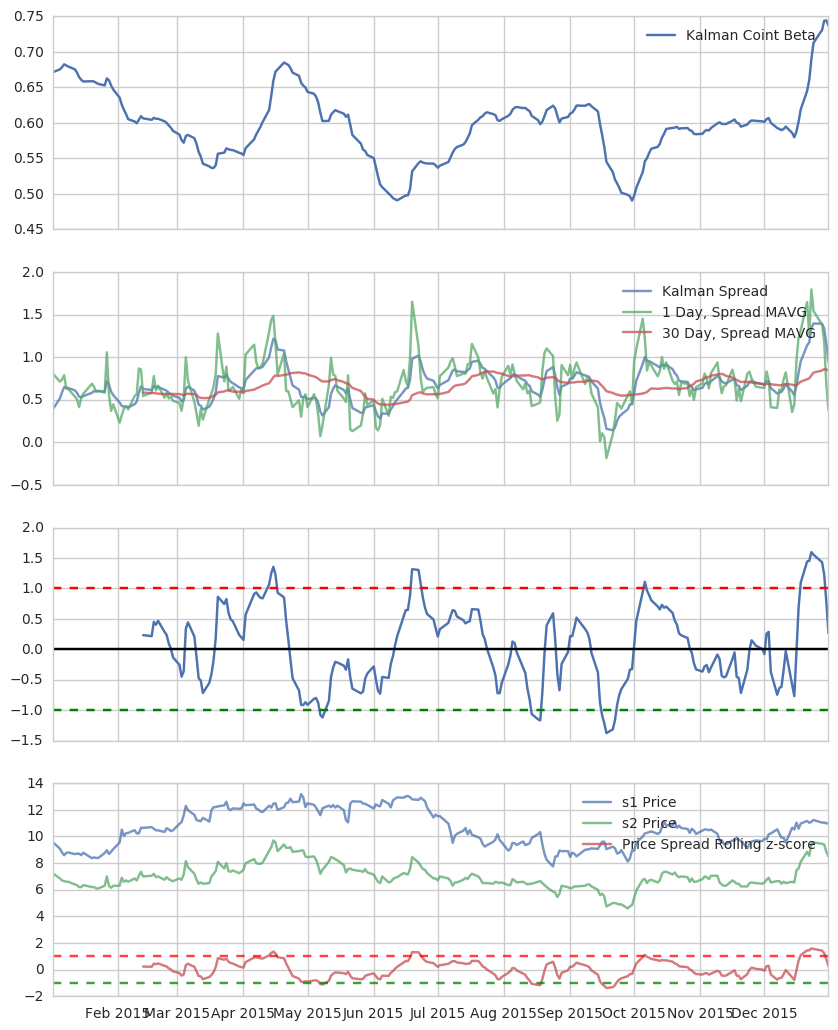

In [514]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[0]])

pair: ( REGI ,  BLDP )
Cointegration p_value over given data:  0.592312689147


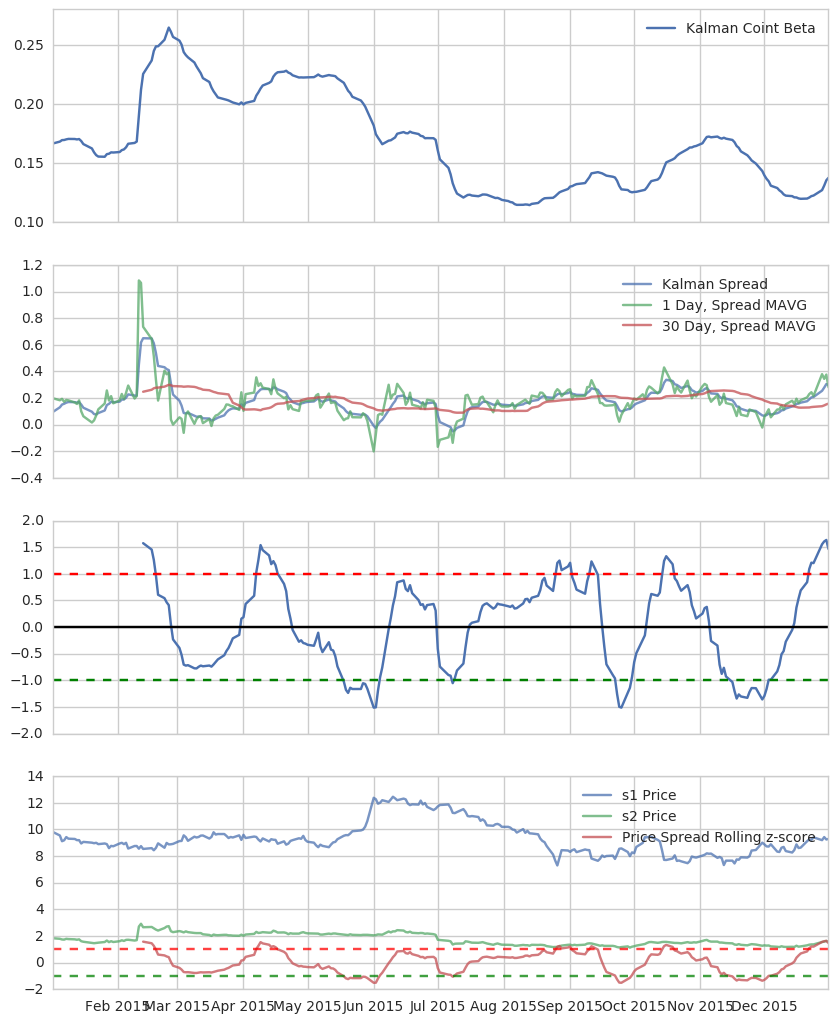

In [515]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[1]])

pair: ( JASO ,  OPTT )
Cointegration p_value over given data:  0.55710856218


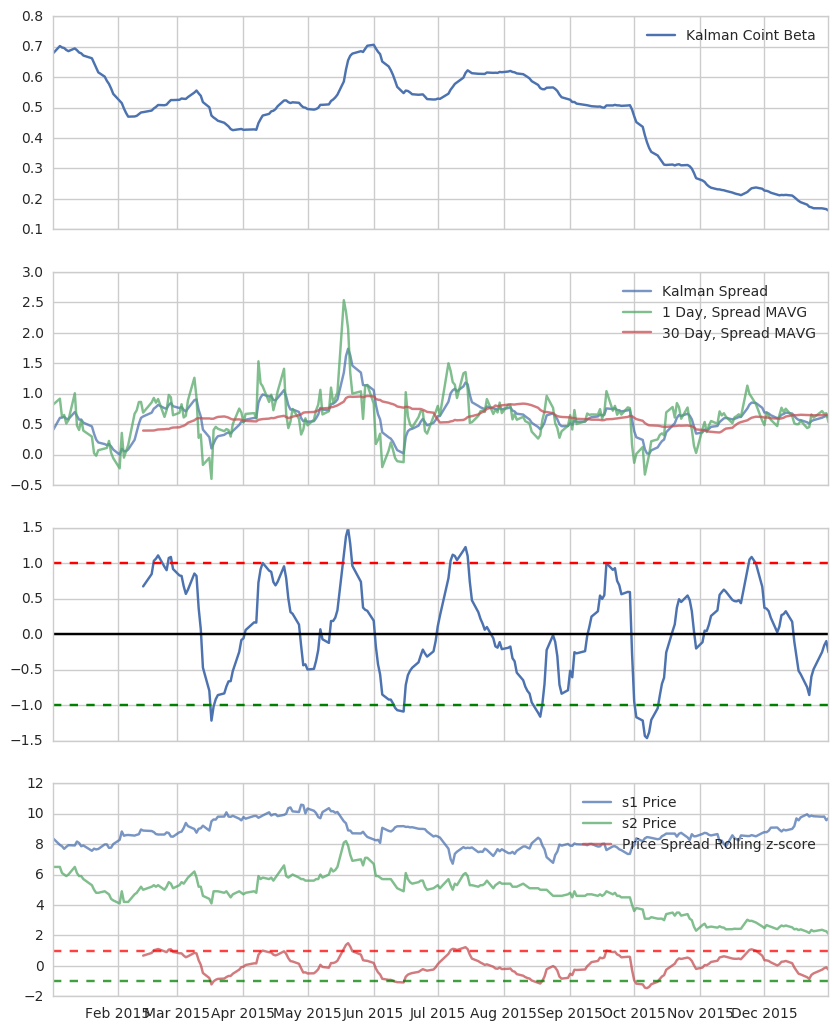

In [516]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[3]])

pair: ( CSUN ,  YGE )
Cointegration p_value over given data:  0.33357575466


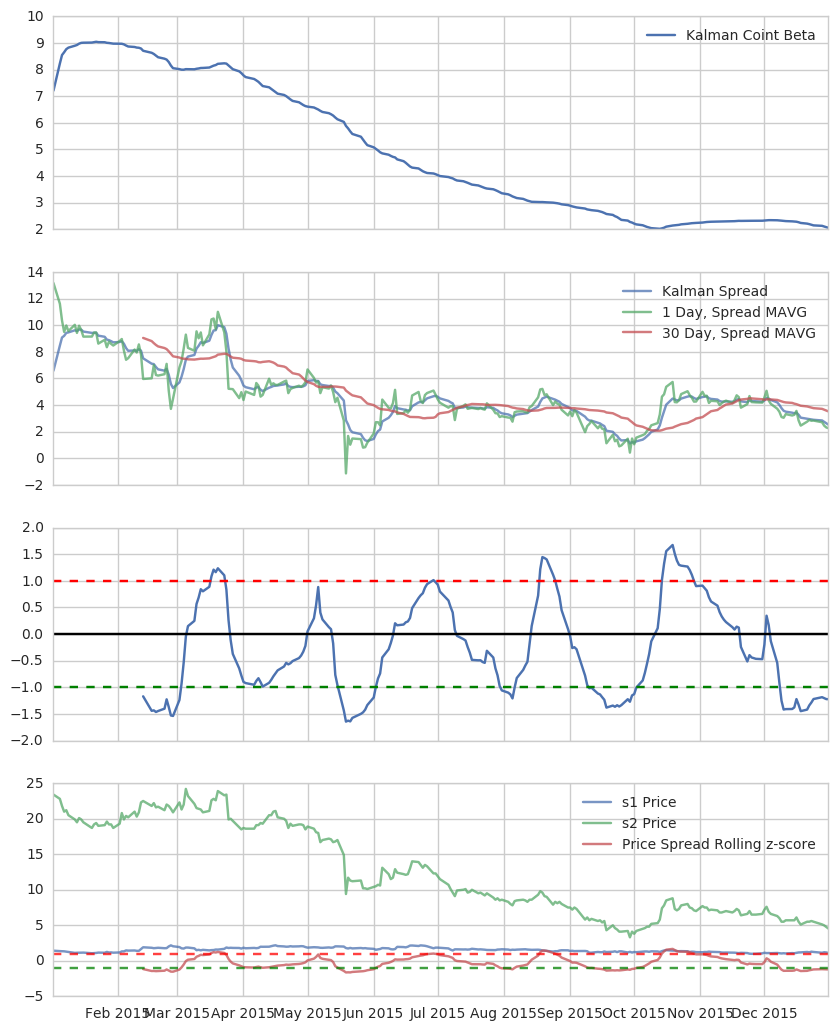

In [517]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[4]])

pair: ( JASO ,  GEVO )
Cointegration p_value over given data:  0.56326544316


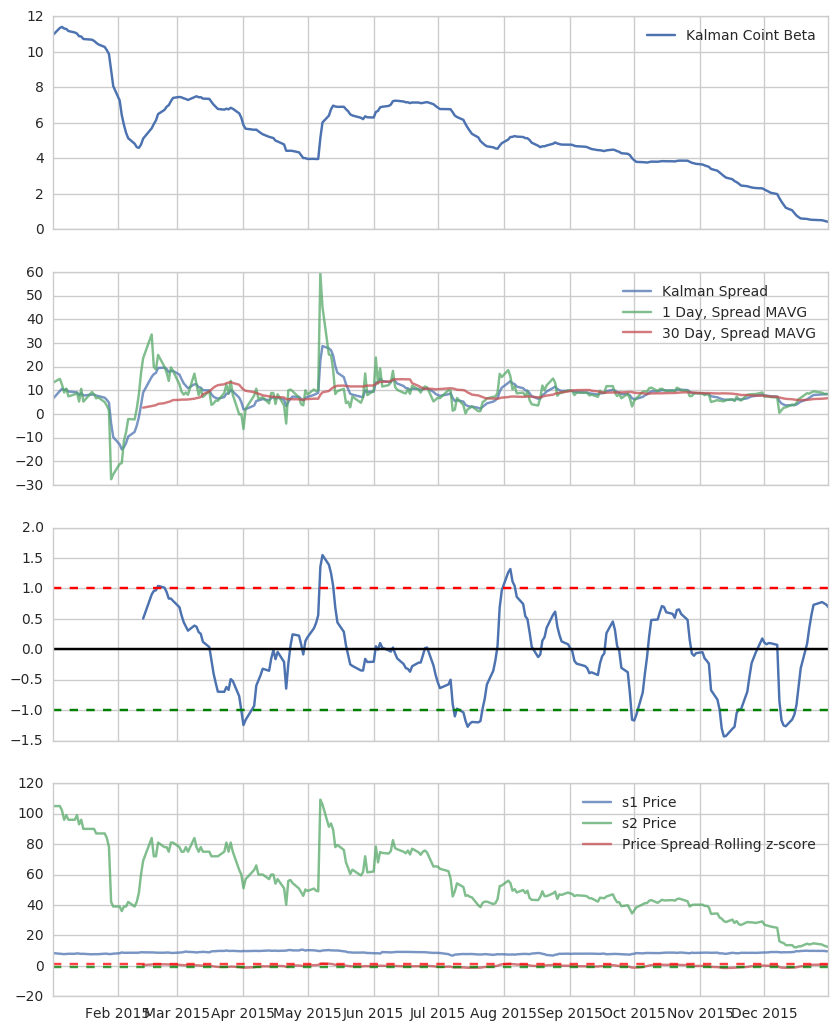

In [518]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[5]])

pair: ( REGI ,  FSLR )
Cointegration p_value over given data:  0.672213074395


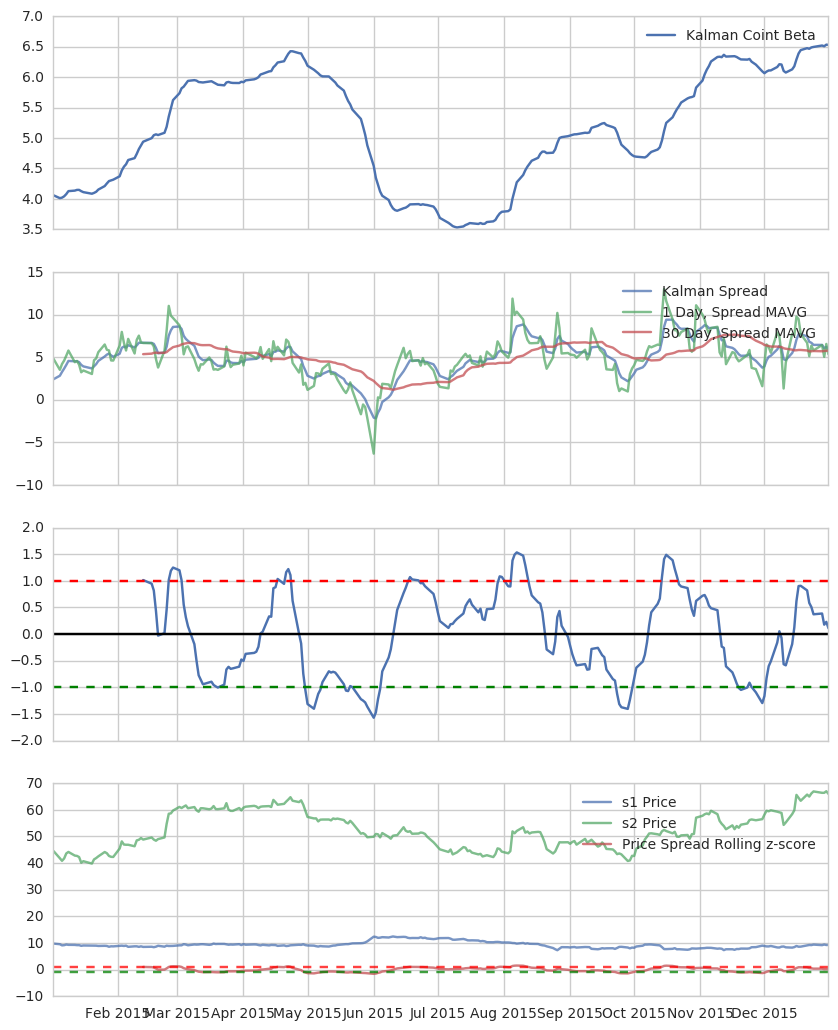

In [522]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[6]])

# Summary

To create the plots above, I first found pairs that were cointegrated during the last few months of 2014. I then used out of sample price data from 2015 to model the cointegration relationship using a Kalman filter for the cointegration beta, then another kalman filter for the cointegration spread. I then plotted the difference between the Kalman spread and a 30-day moving average of the real spread. Then using the real spread, I calculated the 30 day rolling window of the standard deviation in order to calculate z-scores and trigger lines. I think that we could potentially move to implementing an algorithm based of these ideas.

## Pair selection

I began with a list of stock in the renewable energy industry. Then with that narrowed field I calculated the cointegration relationships. This way we lessen (don't eliminate) the issue of multiple cmparison, as well as eliminate the number of computations.

## Kalman Implementation
Straight out of the Kalman filter Quantopian lecure. I only altered the inputs.